# One Jupyter notebook. From GeoJSON to .xml 

## Imports

In [1]:
import json
import geojson 
import geopandas
import pandas as pd
import numpy as np
import os
import datetime as dt

from lmd.lib import Collection, Shape
from lmd import tools
from PIL import Image
from lmd.lib import SegmentationLoader

import tifffile
import string

from shapely.geometry import Point, LineString

In [2]:
# show current anaconda env
print ("Current Conda Environment: " + str(os.environ['CONDA_DEFAULT_ENV']))

Current Conda Environment: py-lmd-env


## From GeoJSON to Dataframe

In [77]:
#user defined variables:

path_to_file = "Z:/Users/Jose/1_Projects/JN_P10_FlorianW_MouseHeart/FlorianW_MouseHeart/'
file = r'230307_187_Frame_all.geojson'
calibration_points = ['calib12','calib13','calib20']

#change batch to True if you want to process many geoJSON, it assumes they all have the same calibration points
batch=False
#if processing batch it assumes calibration points ['Calib1','Calib2','Calib3']

### Samples and wells

In [1]:
#if you want to pass a custom well loadout use the following dictionary:  
#A,B,C,D will have to be the class name used in qupath, it has to be the exact name.  
#please choose wells with a 2-row 2-column margin. not rows (A, B, N, O) not columns (1,22,23)  
#remember the shift between software and collection in the lmd.  

In [79]:
samples_and_wells = {
 '187_HBC_mid_3': 'C3',
 '187_HBC_nVEC_1': 'C4',
 '187_HBC_nVEC_2': 'C5',
 '187_HBC_mid_2': 'C6',
 '187_HBC_nTroph_3': 'C7',
 '187_HBC_nTroph_1': 'C8',
 '187_HBC_mid_1': 'C9',
 '187_HBC_nVEC_3': 'C10',
 '187_HBC_nTroph_2': 'C11',
 '108_STB_nVEC_1': 'F3',
 '108_STB_nVEC_2': 'F4',
 '108_STB_nVEC_3': 'F5',
 '108_STB_gen_1': 'F6',
 '108_STB_gen_2': 'F7',
 '108_STB_gen_3': 'F8',
 '108_CTB_1_1': 'F9',
 '108_CTB_2_1': 'F10',
 '108_CTB_3_1': 'F11',
 '108_HBC_nTroph_1': 'G3',
 '108_HBC_nTroph_2': 'G4',
 '108_HBC_nTroph_3': 'G5',
 '108_HBC_nVEC_1': 'G6',
 '108_HBC_nVEC_2': 'G7',
 '108_HBC_nVEC_3': 'G8',
 '108_HBC_mid_1': 'G9',
 '108_HBC_mid_2': 'G10',
 '108_HBC_mid_3': 'G11',
 '108_CCT_1': 'H3',
 '108_CCT_2': 'H4',
 '108_CCT_3': 'H5',
 '108_VEC_1': 'H6',
 '108_VEC_2': 'H7',
 '108_VEC_3': 'H8',
 '108_Str_1': 'H9',
 '108_Str_2': 'H10',
 '108_Str_3': 'H11',
 '187_STB_nVEC_1': 'D3',
 '187_STB_nVEC_2': 'D4',
 '187_STB_nVEC_3': 'D5',
 '187_STB_gen_1': 'D6',
 '187_STB_gen_2': 'D7',
 '187_STB_gen_3': 'D8',
 '187_CTB_1': 'D9',
 '187_CTB_2': 'D10',
 '187_CTB_3': 'D11',
 '187_CCT_1': 'E3',
 '187_CCT_2': 'E4',
 '187_CCT_3': 'E5',
 '187_VEC_1': 'E6',
 '187_VEC_2': 'E7',
 '187_VEC_3': 'E8',
 '187_str_1': 'E9',
 '187_str_2': 'E10',
 '187_str_3': 'E11'}

## Code

### process dataframe

In [80]:
single_file_path = os.path.join(path_to_file,file)

def start_pipeline(dataf):
    return dataf.copy()
              
def remove_calib_points(df):
    #convert entire df to text
    df_str = df.astype(str)
    #filter original df by finding the word polygon, poly_df created
    poly_df = df[df_str['geometry'].str.contains("POLYGON")]
    poly_df = poly_df.reset_index(drop=True)
    return(poly_df)              

def replace_coords(df):
    df['lol'] = np.nan
    df['lol'] = df['lol'].astype('object')
    
    for i in df.index:
        #get geometry object for row i
        geom=df.at[i, 'geometry']
        #list the coordenate points as tuples
        tmp = list(geom.exterior.coords)
        #transform list of tuples to list of lists
        tmp_lol = [list(i) for i in tmp]
        #add list of list to lol column
        df.at[i,'lol'] = tmp_lol
    return(df)
      
def replace_coords_simple(df):
    df['lol_simple'] = np.nan
    df['lol_simple'] = df['lol_simple'].astype('object')
    df['simple'] = df.geometry.simplify(1)
    
    for i in df.index:
        #get geometry object for row i
        geom=df.at[i, 'simple']
        #list the coordenate points as tuples
        tmp = list(geom.exterior.coords)
        #transform list of tuples to list of lists
        tmp_lol = [list(i) for i in tmp]
        #add list of list to lol column
        df.at[i,'lol_simple'] = tmp_lol
    return(df)

def remove_unclassified_polygons(df):
    if df['classification'].isna().sum() !=0 :
        print(f"you have {df['classification'].isna().sum()} NaNs in your classification column")
        print('these are unclassified objects from Qupath, they will be ignored') 
    df = df[df['classification'].notna()]
    return df

def get_contour_type(df):
    #creates a column for polygon type
    #assumes only polygons in dataframe
    #create empty column
    df['Name'] = np.nan
    #fill empty column with whatever is inside dictionary name entry  
    for i in df.index:
        tmp = df.classification[i].get('name')
        df.at[i,'Name'] = tmp
    return(df)
              
def get_calib_points(list_of_calibpoint_names, df):
    #create shape list
    pointlist = []
    for point_name in list_of_calibpoint_names:
        if point_name in df['name'].unique():
            pointlist.append(df.loc[df['name'] == point_name, 'geometry'].values[0])
        else:
            print('your given calib name is not present in the file, change it and try again')
            print('these are the calib points you passed: ')
            print(list_of_calibpoint_names)
            print('these are the calib points found in the geojson you gave me: ')
            print(df['name'].unique())
            
    #create coordenate list
    listarray = []
    for point in pointlist:
        listarray.append([point.x, point.y])
    nparray = np.array(listarray)
    return(nparray)

### Utilities

In [81]:
#utilities

#Create a datafrate for polygons with a specific name, if it contains a string

def filter_table_by_name(df, string):
    new_df = df.copy()
    new_df = new_df[new_df['Name'].str.contains(string)]
    return new_df

#list all geoJSON files in a given path
def list_geoJSON_in_path(path):
    filelist = os.listdir(path)
    #filter the files so there are only images
    filelist =  [x for x in filelist if '.geojson' in x]
    return filelist

### Pipe from dataframe to xml

In [82]:
def dataframe_to_xml_v2():
    
    df = geopandas.read_file(single_file_path)
    caliblist = get_calib_points(calibration_points, df)
    clean_df = (df
                 .pipe(start_pipeline)
                 .pipe(remove_calib_points)
                 .pipe(replace_coords)
                 .pipe(replace_coords_simple)
                 .pipe(remove_unclassified_polygons)
                 .pipe(get_contour_type))

    
    
    #load the classes 
    #classes represent all the different wells, each class goes into one well.
    all_classes = clean_df.Name.unique()
    
    #create list of acceptable wells, default is using a space in between columns
    list_of_acceptable_wells =[]
    for row in list(string.ascii_uppercase[2:14]):
        for column in range(2,22):
            list_of_acceptable_wells.append(str(row) + str(column))
            
    #samples_and_wells will be dictionary,key is the sample class, value is the well string
    #loads global variable with that name
    global samples_and_wells 
    try:
        samples_and_wells
        print("samples_and_wells was preloaded, using it for assigning wells")
    except NameError:
        print("samples_and_wells not detected, assigning wells at random")
        samples_and_wells = {}
        for sample_class, well in zip(all_classes, list_of_acceptable_wells):
            samples_and_wells[sample_class] = well
        
    #create the collection of py-lmd-env package
    #uses caliblist passed on the function, order matters
    #orientation vector is for QuPath coordenate system
    the_collection = Collection(calibration_points = caliblist)
    the_collection.orientation_transform = np.array([[1,0 ], [0,-1]])
    print('\nusing simplified shapes')
    for i in clean_df.index:
        the_collection.new_shape(clean_df.at[i,'lol_simple'], 
                                    well = samples_and_wells[clean_df.at[i, "Name"]])
    

    #save collection as xml
    print('these are your calibration point coordenates')
    output_name= os.path.splitext(single_file_path)[0]+'.xml'
    the_collection.save(output_name)
    
    #________________________________________________________
    #Information for user
    #________________________________________________________
    
    #create and export dataframe with sample placement in 384 well plate
    rows_A_P= [i for i in string.ascii_uppercase[:16]]
    columns_1_24 = [str(i) for i in range(1,25)]
    df_wp384 = pd.DataFrame(0,columns=columns_1_24, index=rows_A_P)
    
    for i in samples_and_wells:
        location = samples_and_wells[i]
        df_wp384.at[location[0],location[1:]] = i
    df_wp384_output_name = os.path.splitext(single_file_path)[0]+'_384_wellplate.csv'
    print('\n csv file of 384 well plate positions, saved as: ')
    print(df_wp384_output_name)
    df_wp384.to_csv(df_wp384_output_name, index=True)
    
    #print statistics about collection
    print('')
    print(the_collection.stats())
    #plot diagram of all shapes with calibpoints
    the_collection.plot(calibration = True)    
    
    #print where file was saved
    print('\n xml file saved as: ')
    print(output_name)
    
    #create a printlist of all classes, with their wells, and the number of contours 
    printlist = []
    for i in clean_df.Name.unique():
        sublist=[]
        sublist.append(i)
        sublist.append(samples_and_wells[i])
        sublist.append(clean_df[clean_df.Name == i]['Name'].shape[0])
        printlist.append(sublist)
    
    #print the printlist in a human readable format
    print('\n')
    print('Sample','-----------','Well','--','How many contours\n')
    #sort for the order of the class name
    printlist.sort(key=lambda x: x[0])
    for i in range(len(printlist)):
        if printlist[i][0] in list(clean_df.Name):
            space1_number = 18 - len(printlist[i][0])
            space1 = '-' * int(space1_number)
            space2_number = 5 - len(printlist[i][1])
            space2 = '-' * int(space2_number)
            print(printlist[i][0], space1, printlist[i][1], space2, printlist[i][2])

## Processing from GeoJSON to Dataframe

you have 3 NaNs in your classification column
these are unclassified objects from Qupath, they will be ignored
samples_and_wells was preloaded, using it for assigning wells

using simplified shapes
these are your calibration point coordenates
[1134379. -690013.]
[  963517. -1476484.]
[   64212. -1410367.]

 csv file of 384 well plate positions, saved as: 
Z:/Users/Jose/6_Software/Jupyter/20230127_Qupath_Contour/test_geojson_files/230307_187_Frame_all384_wellplate.csv

===== Collection Stats =====
Number of shapes: 2,110
Number of vertices: 29,579
Mean vertices: 14
Min vertices: 9
5% percentile vertices: 10
Median vertices: 13
95% percentile vertices: 20
Max vertices: 30
None


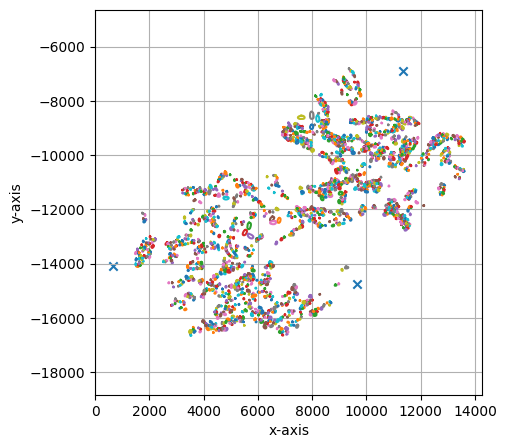


 xml file saved as: 
Z:/Users/Jose/6_Software/Jupyter/20230127_Qupath_Contour/test_geojson_files/230307_187_Frame_all.xml


Sample ----------- Well -- How many contours

187_CTB_1 --------- D9 --- 111
187_CTB_2 --------- D10 -- 111
187_CTB_3 --------- D11 -- 111
187_HBC_mid_1 ----- C9 --- 131
187_HBC_mid_2 ----- C6 --- 129
187_HBC_mid_3 ----- C3 --- 128
187_HBC_nTroph_1 -- C8 --- 152
187_HBC_nTroph_2 -- C11 -- 152
187_HBC_nTroph_3 -- C7 --- 151
187_HBC_nVEC_1 ---- C4 --- 94
187_HBC_nVEC_2 ---- C5 --- 94
187_HBC_nVEC_3 ---- C10 -- 93
187_STB_gen_1 ----- D6 --- 54
187_STB_gen_2 ----- D7 --- 53
187_STB_gen_3 ----- D8 --- 53
187_STB_nVEC_1 ---- D3 --- 42
187_STB_nVEC_2 ---- D4 --- 42
187_STB_nVEC_3 ---- D5 --- 40
187_VEC_1 --------- E6 --- 120
187_VEC_2 --------- E7 --- 120
187_VEC_3 --------- E8 --- 119
187_str_1 --------- E9 --- 4
187_str_2 --------- E10 -- 3
187_str_3 --------- E11 -- 3


In [83]:
#options: 
#write down batch=True inside parentheses if you are processing a series of files
dataframe_to_xml_v2()